In [1]:
import os
import zipfile
import requests
from io import BytesIO
from typing import Tuple, List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Parameters
img_size = (224, 224)
batch_size = 32

In [3]:
def create_dataframe_from_directory(path: str) -> pd.DataFrame:
    classes = []
    class_paths = []
    for label in os.listdir(path):
        label_dir = os.path.join(path, label)
        if os.path.isdir(label_dir):
            for image in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image)
                class_paths.append(image_path)
                classes.append(label)
    
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

In [4]:
def plot_class_distribution(df: pd.DataFrame) -> None:
    plt.figure(figsize=(15, 7))
    ax = sns.countplot(data=df, y='Class', hue='Class', palette='viridis', dodge=False)
    
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Count of images in each class', fontsize=20)
    
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', padding=10)
    
    plt.show()

In [5]:
def plot_sample_images(generator, classes, num_samples=16):
    images, labels = next(generator)
    plt.figure(figsize=(20, 20))
    
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        class_name = classes[np.argmax(labels[i])]
        plt.title(class_name, color='k', fontsize=20)
    
    plt.show()

In [6]:
def create_image_generators(df_train: pd.DataFrame, 
                            df_valid: pd.DataFrame, 
                            df_test: pd.DataFrame,
                            batch_size: int = 16, 
                            img_size: Tuple[int, int] = (224, 224)) -> Tuple[ImageDataGenerator, ImageDataGenerator, ImageDataGenerator]:
    train_datagen = ImageDataGenerator(
        brightness_range=(0.8, 1.2),
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=40
    )
    
    valid_test_datagen = ImageDataGenerator()
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col='Class Path',
        y_col='Class',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'
    )
    
    valid_gen = valid_test_datagen.flow_from_dataframe(
        dataframe=df_valid,
        x_col='Class Path',
        y_col='Class',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'
    )
    
    test_gen = valid_test_datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='Class Path',
        y_col='Class',
        batch_size=batch_size,
        target_size=img_size,
        shuffle=False,
        class_mode='categorical'
    )
    
    return train_gen, valid_gen, test_gen

In [7]:
def build_model(base_model_name: str, num_classes: int) -> Model:
    if base_model_name == 'Xception':
        base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x) 
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
def plot_training_history(history: tf.keras.callbacks.History) -> None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
def plot_confusion_matrix(y_true: pd.Series, y_pred: List[str], class_names: List[str]) -> None:
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [10]:
# Load and prepare data
train_path = './Dataset/train'
test_path = './Dataset/test'

In [11]:
train_df = create_dataframe_from_directory(train_path)
test_df = create_dataframe_from_directory(test_path)

In [12]:
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20)

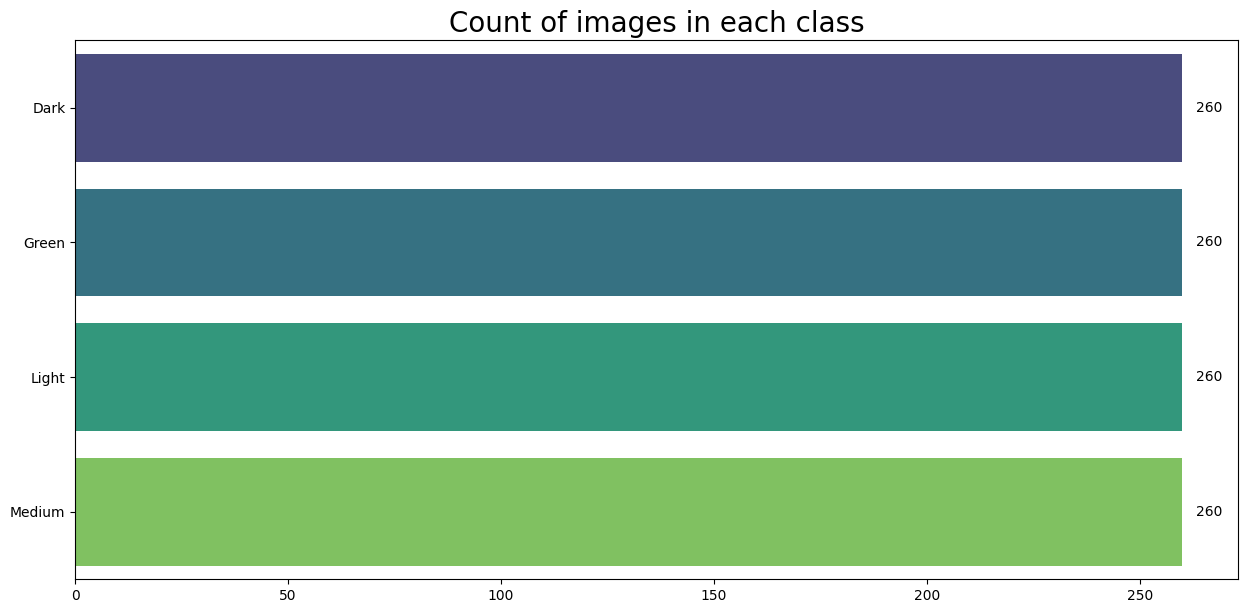

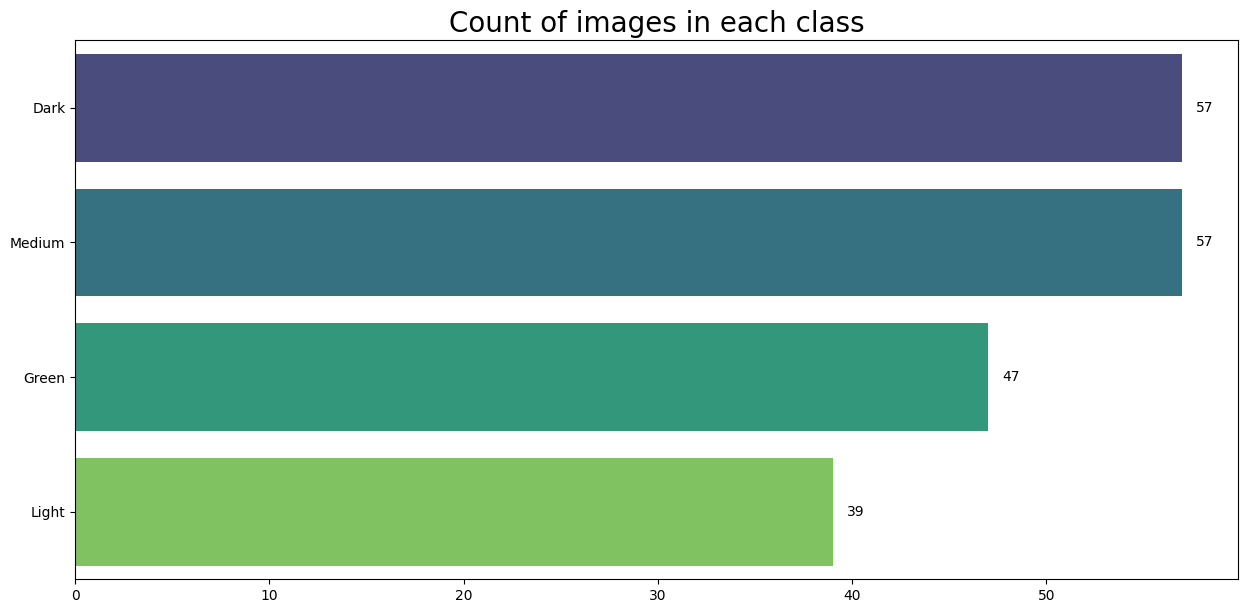

In [13]:
plot_class_distribution(train_df)
plot_class_distribution(test_df)

In [14]:
train_gen, valid_gen, test_gen = create_image_generators(train_df, valid_df, test_df, batch_size=batch_size, img_size=img_size)

Found 1040 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


In [15]:
num_classes = len(train_gen.class_indices)

In [16]:
# Build and compile model
base_model_ResNet50 = 'ResNet50'  
# base_model_Xception = 'Xception'  
# base_model_InceptionV3 = 'InceptionV3'  

model_ResNet50 = build_model(base_model_ResNet50, num_classes)

In [17]:
model_ResNet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

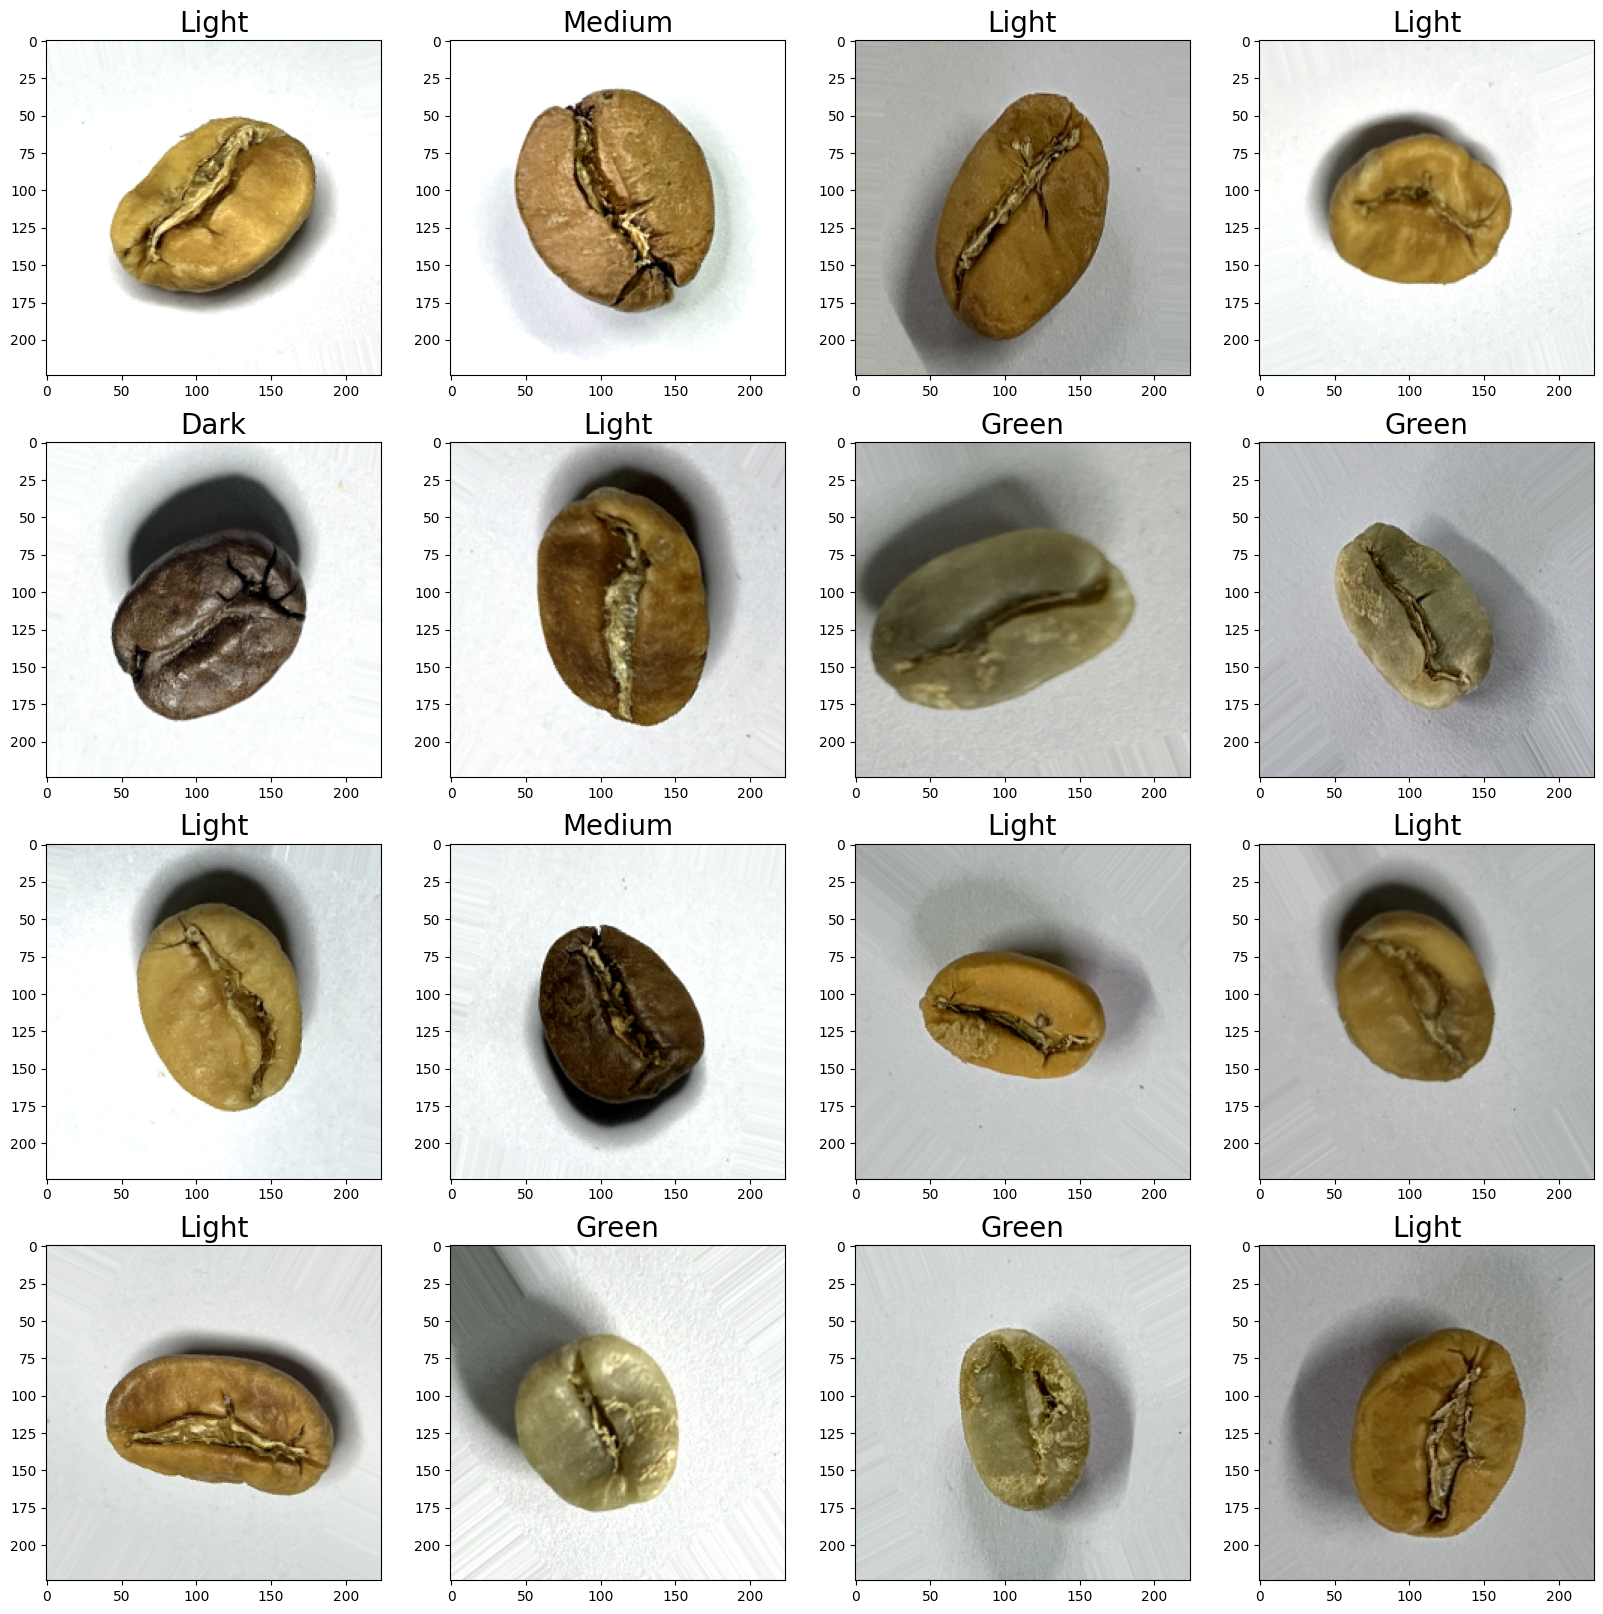

In [18]:
# Plot sample images
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
plot_sample_images(train_gen, classes)

### Train the model

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [20]:
history_ResNet50 = model_ResNet50.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/5


c:\Sevann\UBA\vision_computadora_II\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step - accuracy: 0.8140 - loss: 0.5829 - val_accuracy: 0.4700 - val_loss: 57.5205
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 266s 8s/step - accuracy: 0.9606 - loss: 0.1132 - val_accuracy: 0.7850 - val_loss: 5.5297
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 267s 8s/step - accuracy: 0.9843 - loss: 0.0528 - val_accuracy: 0.8100 - val_loss: 0.7134
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 264s 8s/step - accuracy: 0.9902 - loss: 0.0319 - val_accuracy: 0.8300 - val_loss: 0.9223
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 267s 8s/step - accuracy: 0.9895 - loss: 0.0376 - val_accuracy: 0.9800 - val_loss: 0.0683


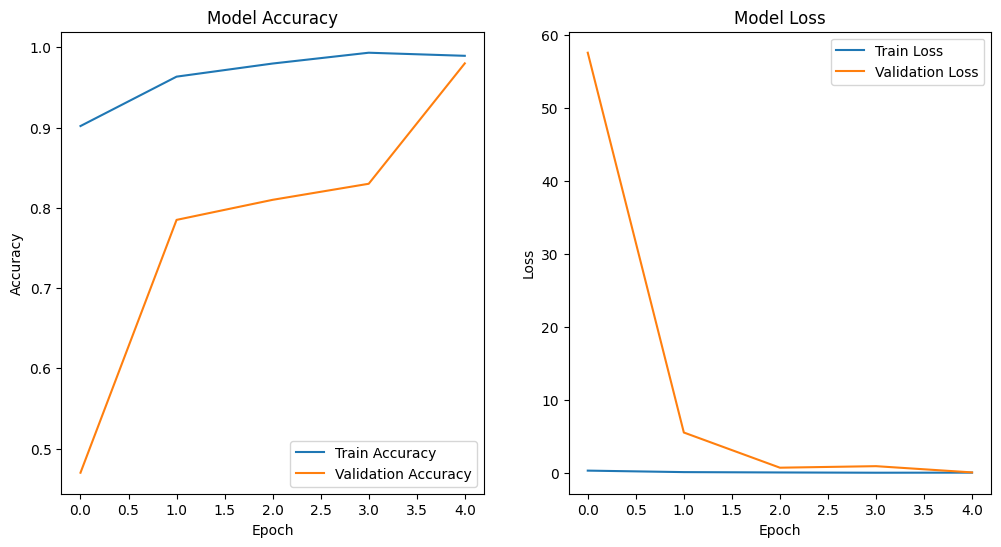

In [21]:
# Plot training history
plot_training_history(history_ResNet50)

In [22]:
# Evaluate the model
test_gen.reset()
y_pred_ResNet50 = model_ResNet50.predict(test_gen)
y_pred_classes_ResNet50 = np.argmax(y_pred_ResNet50, axis=1)
class_names = list(train_gen.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [23]:
# Convert predictions to class names
y_true = test_df['Class']
y_true_labels = y_true.astype(str)
y_pred_labels_ResNet50 = [class_names[idx] for idx in y_pred_classes_ResNet50]

In [24]:
# Print classification report and accuracy
print(classification_report(y_true_labels, y_pred_labels_ResNet50))
print(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels_ResNet50):.4f}")

              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00        57
       Green       0.96      1.00      0.98        47
       Light       1.00      0.95      0.97        39
      Medium       1.00      1.00      1.00        57

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Accuracy: 0.9900


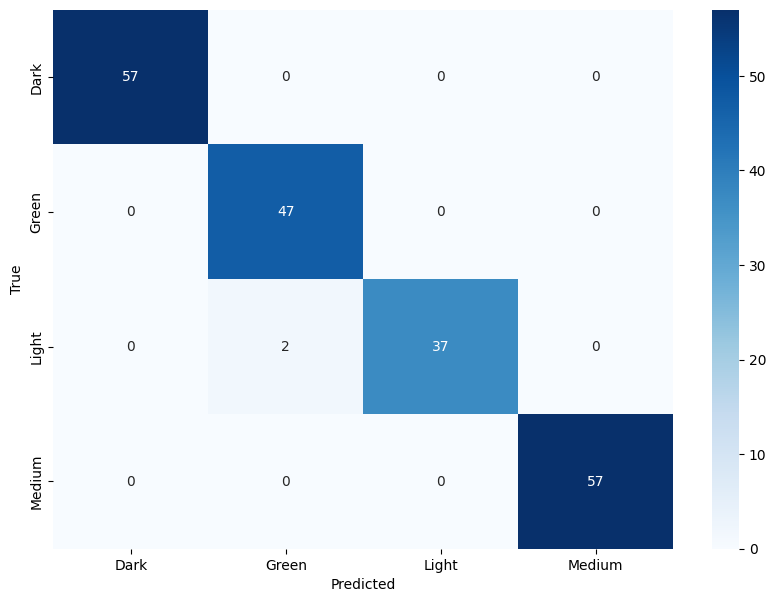

In [25]:
# Plot confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels_ResNet50, class_names)

## Xception

In [26]:
base_model = 'Xception'   
model_Xception = build_model(base_model, num_classes)

In [27]:
model_Xception.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

### Train model

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [29]:
history_Xception = model_Xception.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 430s 12s/step - accuracy: 0.7703 - loss: 0.5666 - val_accuracy: 0.7050 - val_loss: 0.9948
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 412s 12s/step - accuracy: 0.9827 - loss: 0.0811 - val_accuracy: 0.7650 - val_loss: 1.0629
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 412s 12s/step - accuracy: 0.9931 - loss: 0.0335 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 397s 12s/step - accuracy: 0.9764 - loss: 0.0968 - val_accuracy: 1.0000 - val_loss: 2.8857e-04
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 403s 12s/step - accuracy: 0.9936 - loss: 0.0159 - val_accuracy: 0.9850 - val_loss: 0.0226


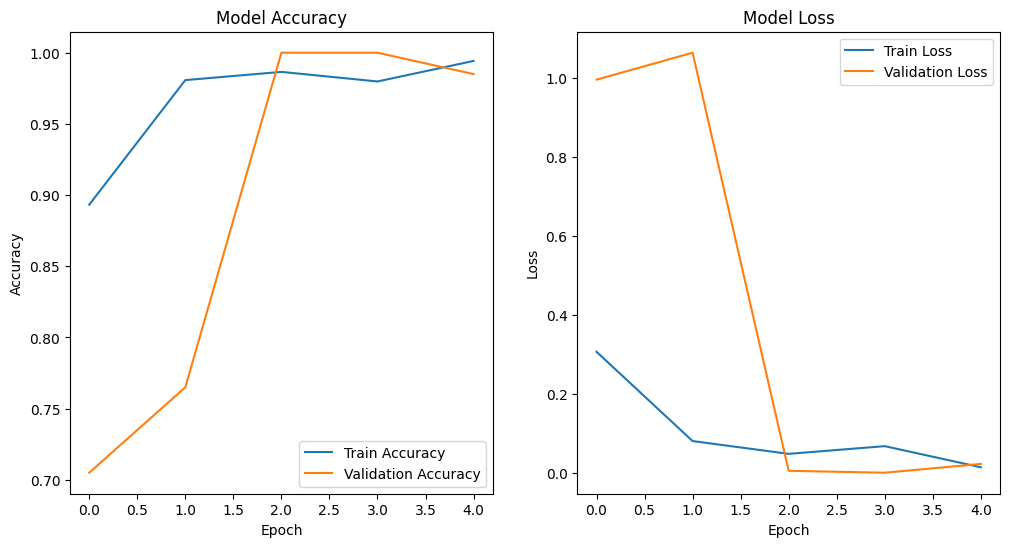

In [30]:
# Plot training history
plot_training_history(history_Xception)

In [31]:
# Evaluate the model
test_gen.reset()
y_pred_Xception = model_Xception.predict(test_gen)
y_pred_classes_Xception = np.argmax(y_pred_Xception, axis=1)
class_names = list(train_gen.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [32]:
# Convert predictions to class names
y_true = test_df['Class']
y_true_labels = y_true.astype(str)
y_pred_labels_Xception = [class_names[idx] for idx in y_pred_classes_Xception]

In [33]:
# Print classification report and accuracy
print(classification_report(y_true_labels, y_pred_labels_Xception))
print(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels_Xception):.4f}")

              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00        57
       Green       1.00      1.00      1.00        47
       Light       0.87      1.00      0.93        39
      Medium       1.00      0.89      0.94        57

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Accuracy: 0.9700


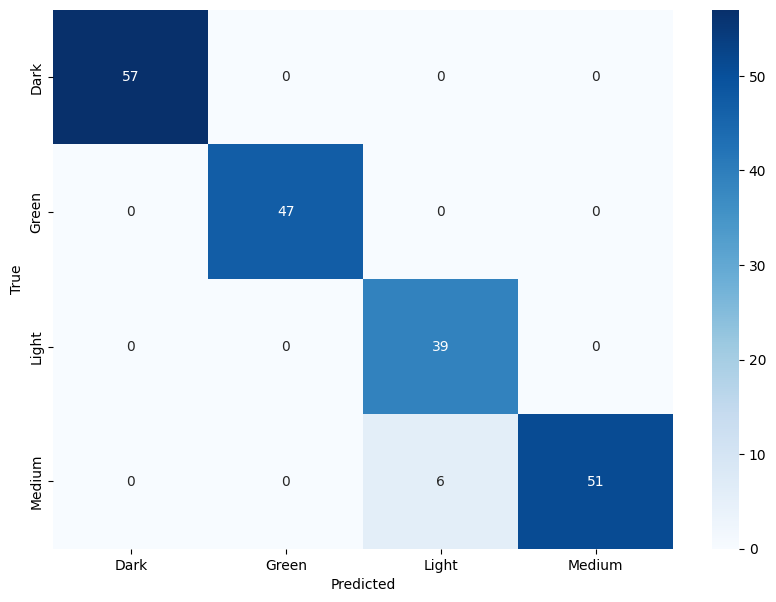

In [34]:
# Plot confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels_Xception, class_names)

## Modelo Alternativo

In [35]:
# from tensorflow.keras.applications import ResNet50, InceptionV3
# from tensorflow.keras.layers import GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint

- ImageDataGenerator facilita la carga de datos y la aplicación de transformaciones en tiempo real, lo que ayuda a mejorar la generalización del modelo.
- Rescalar las imágenes (rescale=1./255) es esencial porque los pesos preentrenados de modelos como ResNet50 y InceptionV3 se ajustan a imágenes en el rango [0, 1].

In [36]:
# # Parámetros de entrada
# input_shape = (224, 224, 3)
# batch_size = 32

# # Generadores de datos para entrenamiento y validación
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2  # Utilizamos un 20% de los datos para validación
# )

# train_generator = train_datagen.flow_from_directory(
#     train_path,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'  # conjunto de entrenamiento
# )

# validation_generator = train_datagen.flow_from_directory(
#     test_path,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'  # conjunto de validación
# )

Aquí elegimos el modelo ResNet50 o InceptionV3. Ambos modelos vienen preentrenados en ImageNet y vamos a reutilizar sus capas convolucionales:

- ResNet50: Este modelo es excelente para tareas de clasificación en imágenes, ya que su arquitectura residual ayuda a mitigar el problema del desvanecimiento del gradiente.
- InceptionV3: Este modelo combina convoluciones de diferentes tamaños y puede capturar información a diferentes escalas, lo que lo hace muy eficaz para la clasificación de imágenes.
- Congelamos las capas del modelo base para aprovechar los pesos preentrenados y solo entrenamos las capas superiores que añadimos.

In [37]:
# # Cargar el modelo base preentrenado en ImageNet
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
# # base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# # Congelar las capas del modelo base
# base_model.trainable = False

# # Agregar capas adicionales
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# # Crear el modelo final
# model = Model(inputs=base_model.input, outputs=predictions)

Ahora compilamos el modelo con un optimizador y una función de pérdida adecuados:

In [38]:
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

Configuración de Callbacks:

In [39]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('coffee_Model.keras', save_best_only=True, monitor='val_loss')

# callbacks = [early_stopping, model_checkpoint]

Entrenamiento del modelo:

In [40]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     epochs=50,
#     callbacks=callbacks
# )

In [41]:
# loss, accuracy = model.evaluate(validation_generator)
# print(f'Validation Loss: {loss}')
# print(f'Validation Accuracy: {accuracy}')

In [42]:
# # Graficar el Accuracy y el Loss
# plt.figure(figsize=(12, 4))

# # Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Entrenamiento')
# plt.plot(history.history['val_accuracy'], label='Validación')
# plt.title('Precisión del Modelo')
# plt.xlabel('Épocas')
# plt.ylabel('Precisión')
# plt.legend()

# # Loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Entrenamiento')
# plt.plot(history.history['val_loss'], label='Validación')
# plt.title('Pérdida del Modelo')
# plt.xlabel('Épocas')
# plt.ylabel('Pérdida')
# plt.legend()

# plt.show()

In [43]:
# # Evaluación en el conjunto de validación
# y_pred = model.predict(validation_generator)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = validation_generator.classes

In [44]:
# # Reporte de clasificación
# print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

In [45]:
# # Matriz de confusión
# cm = confusion_matrix(y_true, y_pred_classes)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
# plt.title('Matriz de Confusión')
# plt.xlabel('Predicción')
# plt.ylabel('Verdad')
# plt.show()

In [46]:
# def create_image_generators(df_train: pd.DataFrame, df_valid: pd.DataFrame, df_test: pd.DataFrame,
#                             batch_size: int = 16, img_size: Tuple[int, int] = (224, 224)) -> Tuple[ImageDataGenerator, ImageDataGenerator, ImageDataGenerator]:
#     """
#     Create ImageDataGenerator instances for training, validation, and testing.

#     Args:
#         df_train (pd.DataFrame): DataFrame with training image paths and class labels.
#         df_valid (pd.DataFrame): DataFrame with validation image paths and class labels.
#         df_test (pd.DataFrame): DataFrame with test image paths and class labels.
#         batch_size (int): Number of images to yield per batch.
#         img_size (Tuple[int, int]): Target size of the images.

#     Returns:
#         Tuple[ImageDataGenerator, ImageDataGenerator, ImageDataGenerator]: ImageDataGenerator instances for training, validation, and testing.
#     """
#     train_datagen = ImageDataGenerator(
#         rescale=1./255,  # Normalizar las imágenes
#         brightness_range=(0.8, 1.2),
#         rotation_range=20,  # Rotaciones aleatorias
#         width_shift_range=0.2,  # Cambios de escala horizontal
#         height_shift_range=0.2,  # Cambios de escala vertical
#         shear_range=0.2,  # Cortes aleatorios
#         zoom_range=0.2,  # Zoom aleatorio
#         horizontal_flip=True  # Flip horizontal
#     )
#     valid_test_datagen = ImageDataGenerator(rescale=1./255)

#     train_gen = train_datagen.flow_from_dataframe(
#         dataframe=df_train,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size
#     )

#     valid_gen = valid_test_datagen.flow_from_dataframe(
#         dataframe=df_valid,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size
#     )

#     test_gen = valid_test_datagen.flow_from_dataframe(
#         dataframe=df_test,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size,
#         shuffle=False
#     )

#     return train_gen, valid_gen, test_gen


In [47]:
# def plot_sample_images(generator, classes, num_samples=16):
#     """
#     Muestra una muestra de imágenes con sus respectivas clases.

#     Args:
#         generator (tf.keras.preprocessing.image.ImageDataGenerator): Generador de imágenes.
#         classes (list): Lista de clases.
#         num_samples (int): Número de imágenes a mostrar.
#     """
#     images, labels = next(generator)
#     plt.figure(figsize=(20, 20))

#     for i in range(num_samples):
#         plt.subplot(4, 4, i + 1)
#         image = images[i]
#         plt.imshow(image)
#         class_name = classes[np.argmax(labels[i])]
#         plt.title(class_name, color='k', fontsize=20)
#         plt.axis('off')  # Eliminar los ejes para mejor visualización
    
#     plt.show()


In [48]:
# train_gen, valid_gen, test_gen = create_image_generators(train_df, valid_df, test_df)

In [49]:
# # Build and compile model
# num_classes = len(train_gen.class_indices)
# model = build_model(num_classes)

In [50]:
# # Model summary
# model.summary()

In [51]:
# # Plot sample images
# class_dict = train_gen.class_indices
# classes = list(class_dict.keys())
# plot_sample_images(train_gen, classes)

In [52]:
# # Train the model
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)
# history = model.fit(
#     train_gen,
#     epochs=5,
#     validation_data=valid_gen,
#     shuffle=True,
#     callbacks=[early_stopping]
# )

In [53]:
# # Plot training history
# plot_training_history(history)

In [54]:
# # Evaluate the model
# test_gen.reset()
# y_pred = model.predict(test_gen)
# y_pred_classes = np.argmax(y_pred, axis=1)
# class_names = list(train_gen.class_indices.keys())

In [55]:
# # Convert predictions to class names
# y_true = test_df['Class']
# y_pred_labels = [class_names[idx] for idx in y_pred_classes]

In [56]:
# # Print classification report and accuracy
# print(classification_report(y_true, y_pred_labels))
# print(f"Accuracy of the Model: {accuracy_score(y_true, y_pred_labels) * 100:.1f}%")

In [57]:
# # Plot confusion matrix
# plot_confusion_matrix(y_true, y_pred_labels, class_names)

In [58]:
# # Save the model
# model.save("coffee_Model.h5")

In [59]:
# # Additional Data Augmentation Techniques
# train_datagen = ImageDataGenerator(
#     brightness_range=(0.8, 1.2),
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     rotation_range=40
# )

In [60]:
# # Parameters
# img_size = (224, 224)  # Image size
# batch_size = 32  # Batch size

In [61]:
# train_gen = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='Class Path',
#     y_col='Class',
#     batch_size=batch_size,
#     target_size=img_size
# )

In [62]:
# # Re-train the model with augmented data
# history_aug = model.fit(
#     train_gen,
#     epochs=5,
#     validation_data=valid_gen,
#     shuffle=True,
#     callbacks=[early_stopping]
# )

In [63]:
# # Plot training history for augmented data
# plot_training_history(history_aug)

In [64]:
# # Evaluate the model with augmented data
# test_gen.reset()
# y_pred_aug = model.predict(test_gen)
# y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)
# y_pred_labels_aug = [class_names[idx] for idx in y_pred_classes_aug]

In [65]:
# # Print classification report and accuracy for augmented data
# print("Classification report with augmented data:")
# print(classification_report(y_true, y_pred_labels_aug))
# print(f"Accuracy of the Model with Augmented Data: {accuracy_score(y_true, y_pred_labels_aug) * 100:.1f}%")

In [66]:
# # Plot confusion matrix for augmented data
# print("Confusion Matrix with Augmented Data:")
# plot_confusion_matrix(y_true, y_pred_labels_aug, class_names)

# Xception

In [67]:
# import os
# import zipfile
# import requests
# from io import BytesIO
# from typing import Tuple, List, Dict, Any

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from PIL import Image
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.optimizers import Adamax, Adam
# from tensorflow.keras.metrics import Precision, Recall
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import Xception, ResNet50, InceptionV3
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import GlobalAveragePooling2D

In [68]:
# # Parameters
# img_size = (224, 224) 
# batch_size = 32  

In [69]:
# def create_dataframe_from_directory(path: str) -> pd.DataFrame:
#     """
#     Create a DataFrame from the image directory structure.

#     Args:
#         path (str): Path to the image directory.

#     Returns:
#         pd.DataFrame: DataFrame with image paths and their corresponding class labels.
#     """
#     classes = []
#     class_paths = []
#     for label in os.listdir(path):
#         label_dir = os.path.join(path, label)
#         if os.path.isdir(label_dir):
#             for image in os.listdir(label_dir):
#                 image_path = os.path.join(label_dir, image)
#                 class_paths.append(image_path)
#                 classes.append(label)
    
#     return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

In [70]:
# def plot_class_distribution(df: pd.DataFrame) -> None:
#     """
#     Plot the distribution of classes in the DataFrame.

#     Args:
#         df (pd.DataFrame): DataFrame containing the image paths and class labels.
#     """
#     plt.figure(figsize=(15, 7))
#     ax = sns.countplot(data=df, y='Class', hue='Class', palette='viridis', dodge=False)
    
#     if ax.get_legend() is not None:
#         ax.get_legend().remove()
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.title('Count of images in each class', fontsize=20)
    
#     for container in ax.containers:
#         ax.bar_label(container, label_type='edge', padding=10)
    
#     plt.show()

In [71]:
# def plot_sample_images(generator, classes, num_samples=16):
#     """
#     Muestra una muestra de imágenes con sus respectivas clases.

#     Args:
#         generator (tf.keras.preprocessing.image.ImageDataGenerator): Generador de imágenes.
#         classes (list): Lista de clases.
#         num_samples (int): Número de imágenes a mostrar.
#     """
#     images, labels = next(generator)
#     plt.figure(figsize=(20, 20))

#     for i in range(num_samples):
#         plt.subplot(4, 4, i + 1)
#         image = images[i] / 255
#         plt.imshow(image)
#         class_name = classes[np.argmax(labels[i])]
#         plt.title(class_name, color='k', fontsize=20)
    
#     plt.show()

In [72]:
# def create_image_generators(df_train: pd.DataFrame, df_valid: pd.DataFrame, df_test: pd.DataFrame,
#                             batch_size: int = 16, img_size: Tuple[int, int] = (224, 224)) -> Tuple[ImageDataGenerator, ImageDataGenerator, ImageDataGenerator]:
#     """
#     Create ImageDataGenerator instances for training, validation, and testing.

#     Args:
#         df_train (pd.DataFrame): DataFrame with training image paths and class labels.
#         df_valid (pd.DataFrame): DataFrame with validation image paths and class labels.
#         df_test (pd.DataFrame): DataFrame with test image paths and class labels.
#         batch_size (int): Number of images to yield per batch.
#         img_size (Tuple[int, int]): Target size of the images.

#     Returns:
#         Tuple[ImageDataGenerator, ImageDataGenerator, ImageDataGenerator]: ImageDataGenerator instances for training, validation, and testing.
#     """
#     train_datagen = ImageDataGenerator(
#         brightness_range=(0.8, 1.2),
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=True,
#         rotation_range=40
#     )
    
#     valid_test_datagen = ImageDataGenerator()

#     train_gen = train_datagen.flow_from_dataframe(
#         dataframe=df_train,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size,
#         class_mode='categorical'
#     )

#     valid_gen = valid_test_datagen.flow_from_dataframe(
#         dataframe=df_valid,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size,
#         class_mode='categorical'
#     )

#     test_gen = valid_test_datagen.flow_from_dataframe(
#         dataframe=df_test,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size,
#         shuffle=False,
#         class_mode='categorical'
#     )

#     return train_gen, valid_gen, test_gen

In [73]:
# def build_model_xception(num_classes: int) -> Model:
#     """
#     Build and compile the model using Xception as the base.

#     Args:
#         num_classes (int): Number of classes in the dataset.

#     Returns:
#         Model: Compiled Keras model.
#     """
#     base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)
#     inputs = tf.keras.Input(shape=(224, 224, 3))
#     x = base_model(inputs, training=False)
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = tf.keras.Model(inputs, outputs)
#     model.compile(optimizer=Adamax(learning_rate=0.001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

In [74]:
# def plot_training_history(history: tf.keras.callbacks.History) -> None:
#     """
#     Plot the training and validation accuracy and loss over epochs.

#     Args:
#         history (tf.keras.callbacks.History): History object from the model training.
#     """
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.show()

In [75]:
# def plot_confusion_matrix(y_true: pd.Series, y_pred: np.ndarray, class_names: List[str]) -> None:
#     """
#     Plot the confusion matrix.

#     Args:
#         y_true (pd.Series): True class labels.
#         y_pred (np.ndarray): Predicted class labels.
#         class_names (List[str]): List of class names.
#     """
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
#     plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
#     plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.show()

In [76]:
# # Load and prepare data
# train_path = './Dataset/train'
# test_path = './Dataset/test'

In [77]:
# train_df = create_dataframe_from_directory(train_path)
# test_df = create_dataframe_from_directory(test_path)

In [78]:
# train_df

In [79]:
# valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20)

In [80]:
# plot_class_distribution(train_df)
# plot_class_distribution(test_df)

In [81]:
# train_gen, valid_gen, test_gen = create_image_generators(train_df, valid_df, test_df, batch_size=batch_size, img_size=img_size)

In [82]:
# # Build and compile model
# num_classes = len(train_gen.class_indices)
# model = build_model_xception(num_classes)

In [83]:
# # Model summary
# model.summary()

In [84]:
# # Plot sample images
# class_dict = train_gen.class_indices
# classes = list(class_dict.keys())
# plot_sample_images(train_gen, classes)

In [85]:
# # Train the model
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)
# history = model.fit(
#     train_gen,
#     epochs=5,
#     validation_data=valid_gen,
#     shuffle=True,
#     callbacks=[early_stopping]
# )

In [86]:
# # Plot training history
# plot_training_history(history)

In [87]:
# # Evaluate the model
# test_gen.reset()
# y_pred = model.predict(test_gen)
# y_pred_classes = np.argmax(y_pred, axis=1)
# class_names = list(train_gen.class_indices.keys())

In [88]:
# # Convert predictions to class names
# y_true = test_df['Class']
# # y_pred_labels = [class_names[idx] for idx in y_pred_classes]

# # Convert both y_true and y_pred_labels to categorical (string) labels
# y_true_labels = y_true.astype(str)
# y_pred_labels = [class_names[idx] for idx in y_pred_classes]

In [89]:
# # Print classification report and accuracy
# print(classification_report(y_true_labels, y_pred_labels))
# print(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels):.4f}")

In [90]:
# # Plot confusion matrix
# def plot_confusion_matrix(y_true: pd.Series, y_pred: List[str], class_names: List[str]) -> None:
#     """
#     Plot the confusion matrix.
    
#     Parameters:
#         y_true (pd.Series): True labels.
#         y_pred (List[str]): Predicted labels.
#         class_names (List[str]): List of class names.
#     """
#     cm = confusion_matrix(y_true, y_pred, labels=class_names)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()


In [91]:
# plot_confusion_matrix(y_true_labels, y_pred_labels, class_names)

In [92]:
# # Optionally, save the model
# model.save('trained_model.h5')

In [93]:
# def create_image_generators_xception(df_train: pd.DataFrame, df_valid: pd.DataFrame, df_test: pd.DataFrame,
#                             batch_size: int = 16, img_size: Tuple[int, int] = (224, 224)) -> Tuple[ImageDataGenerator, ImageDataGenerator, ImageDataGenerator]:
    
#     train_datagen = ImageDataGenerator(brightness_range=(0.8, 1.2))
#     valid_test_datagen = ImageDataGenerator()

#     train_gen = train_datagen.flow_from_dataframe(
#         dataframe=df_train,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size
#     )

#     valid_gen = valid_test_datagen.flow_from_dataframe(
#         dataframe=df_valid,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size
#     )

#     test_gen = valid_test_datagen.flow_from_dataframe(
#         dataframe=df_test,
#         x_col='Class Path',
#         y_col='Class',
#         batch_size=batch_size,
#         target_size=img_size,
#         shuffle=False
#     )

#     return train_gen, valid_gen, test_gen

In [94]:
# # Create ImageDataGenerators
# train_gen_xception, valid_gen_xception, test_gen_xception = create_image_generators_xception(train_df, valid_df, test_df)

In [95]:
# # Build and compile model
# num_classes = len(train_gen_xception.class_indices)
# model_xception = build_model_xception(num_classes)

In [96]:
# model_xception.summary()

In [97]:
# # Plot sample images
# class_dict_xception = train_gen_xception.class_indices
# classes_xception = list(class_dict_xception.keys())
# plot_sample_images(train_gen_xception, classes_xception)

In [98]:
# # Train the model
# early_stopping_xception = EarlyStopping(monitor='val_loss', mode='min', patience=3)
# history_xception = model_xception.fit(
#     train_gen_xception,
#     epochs=5,
#     validation_data=valid_gen_xception,
#     shuffle=False,
#     callbacks=[early_stopping_xception]
# )

In [99]:
# # Plot training history
# plot_training_history(history_xception)

In [100]:
# # Evaluate the model
# test_gen_xception.reset()
# y_pred_xception = model_xception.predict(test_gen_xception)
# y_pred_classes_xception = np.argmax(y_pred_xception, axis=1)
# class_names_xception = list(train_gen_xception.class_indices.keys())

In [101]:
# # Convert predictions to class names
# y_true = test_df['Class']
# y_pred_labels_xception = [class_names_xception[idx] for idx in y_pred_classes_xception]

In [102]:
# # Print classification report and accuracy
# print(classification_report(y_true, y_pred_labels_xception))
# print(f"Accuracy of the Model: {accuracy_score(y_true, y_pred_labels_xception) * 100:.1f}%")

In [103]:
# # Plot confusion matrix
# plot_confusion_matrix(y_true, y_pred_labels_xception, class_names_xception)

In [104]:
# # Save the model
# model.save("coffee_Model_xception.h5")